# Analizando Chilenas/os en Wikipedia

Este análisis está basado en Wikidata utilizando las siguientes consultas:

### [Humanos con pais de nacionalidad Chile](https://w.wiki/44Ey)
```
SELECT DISTINCT ?item ?itemLabel ?itemDescription ?sitelinks ?sex_or_gender ?sex_or_genderLabel ?date_of_birth ?place_of_birth ?place_of_birthLabel ?occupation ?occupationLabel ?date_of_death ?member_of_political_party ?member_of_political_partyLabel WHERE {
  ?item wdt:P31 wd:Q5;
    wdt:P27 wd:Q298;
    wikibase:sitelinks ?sitelinks.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "es,en". }
  OPTIONAL { ?item wdt:P21 ?sex_or_gender. }
  OPTIONAL { ?item wdt:P569 ?date_of_birth. }
  OPTIONAL { ?item wdt:P19 ?place_of_birth. }
  OPTIONAL { ?item wdt:P106 ?occupation. }
  OPTIONAL { ?item wdt:P570 ?date_of_death. }
  OPTIONAL { ?item wdt:P102 ?member_of_political_party. }
}
ORDER BY DESC (?sitelinks)
```
[Ir al interfaz de Wikidata](https://w.wiki/44Ey), descargar, y guardar en formato JSON con el nombre chilenosWikipedia.json

### [Humanos con pais de nacionalidad chile, y sus links a Wikis](https://w.wiki/44F2)
```
SELECT DISTINCT ?item ?itemLabel ?itemDescription  ?article 
WHERE {
  ?item wdt:P31 wd:Q5;
    wdt:P27 wd:Q298.
    ?article schema:about ?item
    SERVICE wikibase:label { bd:serviceParam wikibase:language "es,en". }

}
```
[Ir al interfaz de Wikidata](https://w.wiki/44F2), descargar, y guardar en formato JSON con el nombre chilenosSiteLinks.json

In [114]:
import pandas as pd #importamos la libreria pandas para leer nuestros resultados
#leo Chilenos 
chilenos = pd.read_json('chilenosWikipedia.json')
#leo la lista de sitelinks
chilenosSitelinks = pd.read_json('chilenosSiteLinks.json')


In [152]:
#cuento los casos unicos en cada dataframe
print(chilenosSitelinks['item'].nunique(),chilenos['item'].nunique())

In [153]:
#Quito los chilenos con sin sitelink
chilenos = chilenos[chilenos['sitelinks'] >0]

11868 12445


In [279]:
#vuelvo a comprobar y veo que ambas listas tienen la misma cantidad
print(chilenosSitelinks['item'].nunique(),chilenos['item'].nunique())

11868 11868


# Analisis sobre los sitelinks

In [267]:
#defino un par de funciones para transformar extraer información de los links
#esto es necesario para saber a que idioma pertenece el link, y a que proyecto (wikipedia, wikinews, etc)

def getLang(l):
    """esta funcion recibe el link de una pagina (ej. https://es.wikipedia.org/wiki/Pablo_Neruda)
    y retorna el idioma del proyecto (ej. 'es' )
    """
    url = l.split('/')[2]
    return url.split('.')[0]

def getFamiliy(l):
        """esta funcion recibe el link de una pagina (ej. https://es.wikipedia.org/wiki/Pablo_Neruda)
    y retorna la familia projecto (ej. 'wikipedia')
    """
    url = l.split('/')[2]
    return url.split('.')[1]

#Aplico mis funcioes
chilenosSitelinks['sitelink_lang'] = chilenosSitelinks['article'].apply(lambda x: getLang(x))
chilenosSitelinks['sitelink_family'] = chilenosSitelinks['article'].apply(lambda x: getFamiliy(x))

In [281]:
#miro que familia de proyetos tengo
chilenosSitelinks['sitelink_family'].value_counts()

wikipedia     35197
wikimedia      2586
wikiquote       257
wikisource      117
wikinews         32
Name: sitelink_family, dtype: int64

In [268]:
#Ahora filtro, para quedarme sólo con proyectos Wikipedia (descartando otros )
chilenosConWikipedia = chilenosSitelinks[chilenosSitelinks['sitelink_family'] =='wikipedia']

In [158]:
print('numero de chilenos/as con pagina en Wikipedia',chilenosConWikipedia['item'].nunique())

numero de chilenos/as con pagina en Wikipedia 11649


In [159]:
#contamos los que tienen más wikis
chilenosConWikipedia[['itemLabel','sitelink_lang']].groupby('itemLabel').count().sort_values('sitelink_lang',ascending=False)[0:27]

,sitelink_lang
itemLabel,
Pablo Neruda,121
Gabriela Mistral,101
Michelle Bachelet,98
Salvador Allende,97
Augusto Pinochet,97
Sebastián Piñera,74
Claudio Bravo,71
Alexis Sánchez,68
Isabel Allende,68


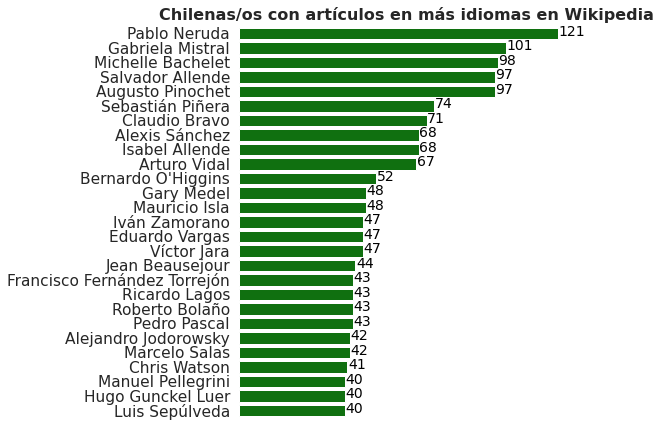

In [161]:
#dibujemoslo más bonito
import seaborn as sb

list_top = chilenosConWikipedia[['itemLabel','sitelink_lang']].groupby('itemLabel').count().sort_values('sitelink_lang',ascending=False)[0:27].index
top_chilenos = chilenosConWikipedia[chilenosConWikipedia['itemLabel'].isin(list_top)][['itemLabel','sitelink_lang']]

descending_order = top_chilenos['itemLabel'].value_counts().sort_values(ascending=False).index
ax = sb.countplot(y = top_chilenos['itemLabel'], order=descending_order,color='green')

sb.despine(fig=None, ax=None, top=True, right=True, left=False, trim=False)
#sb.set(rc={'figure.figsize':(6,7.2)})

ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_title('Chilenas/os con artículos en más idiomas en Wikipedia', fontsize=16, fontweight='heavy')
sb.set(font_scale = 1.4)
ax.axes.get_xaxis().set_visible(False)
ax.set_frame_on(False)

y = top_chilenos['itemLabel'].value_counts().sort_values(ascending=False)
for i, v in enumerate(y):
    ax.text(v + 0.2, i + .16, str(v), color='black', fontweight='light', fontsize=14)
    
ax.get_figure().savefig('topChilenos.png',bbox_inches = 'tight')

In [162]:
#lenguas más comunes
chilenosConWikipedia.sitelink_lang.value_counts()[0:10]

es     10453
en      4535
arz     3335
ar      1949
fr      1455
it      1310
de      1184
tg      1117
pt       950
ru       756
Name: sitelink_lang, dtype: int64

In [163]:
# Chilenos sin Wikipedia en español
chilenosConEs_items = chilenosConWikipedia[chilenosConWikipedia['sitelink_lang'] =='es']['item']
chilenosSinEs = chilenosConWikipedia[~chilenosConWikipedia['item'].isin(chilenosConEs_items)]
countChilenosSinEscount = chilenosSinEs[['itemLabel','itemDescription']].groupby('itemLabel').agg({'itemLabel':'count','itemDescription':'max'})

In [422]:
countChilenosSinEscount.shape

(1194, 2)

In [167]:
countChilenosSinEscount.rename(columns={'itemLabel':'Idiomas'}).sort_values('Idiomas',ascending=False)[0:11]

,Idiomas,itemDescription
itemLabel,,
Carlos Rojas,11,futbolista chileno
Carlos Ibáñez,11,futbolista chileno
Manuel Alberto Claro,10,Cineasta Chileno-Danés
Miguel Flores,10,futbolista chileno
Paulina Gálvez,9,actriz chilena
Héctor Vergara,9,árbitro de fútbol
S. Cofré,8,astrónoma chileno
Robert Frucht,7,Matemático especializado en la simetría de grafos
Domingo Massaro,7,futbolista chileno


# Analisis por genero

In [171]:
chilenosConWikipediaInfo = chilenos[chilenos['item'].isin(chilenosConWikipedia.item.unique().tolist())]

In [282]:
#vemos el %
genero = chilenosConWikipediaInfo[['item','sex_or_genderLabel']].drop_duplicates()
100 * genero['sex_or_genderLabel'].value_counts() /genero.shape[0]

masculino            81.862661
femenino             17.982833
mujer transgénero     0.085837
género fluido         0.008584
Name: sex_or_genderLabel, dtype: float64

In [401]:
genero['sex_or_genderLabel'].value_counts()

masculino            9537
femenino             2095
mujer transgénero      10
género fluido           1
Name: sex_or_genderLabel, dtype: int64

['masculino', 'femenino', 'mujer transgénero', 'género fluido']

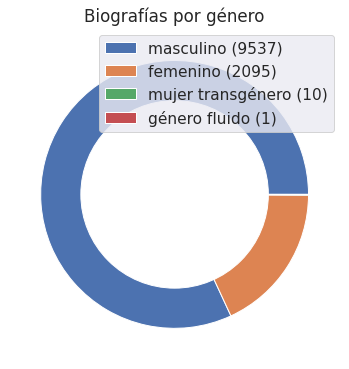

In [420]:
# library
import matplotlib.pyplot as plt

# create data
size_of_groups=genero['sex_or_genderLabel'].value_counts().tolist()

# Create a pieplot
plt.pie(size_of_groups)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

l = ['{0} ({1})'.format(x[0],x[1]) for x in zip(genero['sex_or_genderLabel'].value_counts().index,genero['sex_or_genderLabel'].value_counts())]
plt.legend(l)
plt.title('Biografías por género')
plt.show()

# Ocupación

In [439]:
#vemos las ocupaciones más comunes
chilenosConWikipediaInfo['occupationLabel'].value_counts()[0:20]

político                  2993
futbolista                2280
abogado                   1219
escritor                   796
actor                      751
entrenador de fútbol       638
periodista                 590
empresario                 441
diplomático                341
militar                    332
cantante                   330
poeta                      317
pintor                     316
compositor                 218
economista                 213
músico                     205
médico                     203
historiador                167
profesor universitario     154
director de cine           152
Name: occupationLabel, dtype: int64

In [438]:
# y en %
chilenosConWikipediaInfo['occupationLabel'].value_counts()[0:20] / 11868

político                  0.252191
futbolista                0.192113
abogado                   0.102713
escritor                  0.067071
actor                     0.063279
entrenador de fútbol      0.053758
periodista                0.049714
empresario                0.037159
diplomático               0.028733
militar                   0.027974
cantante                  0.027806
poeta                     0.026710
pintor                    0.026626
compositor                0.018369
economista                0.017947
músico                    0.017273
médico                    0.017105
historiador               0.014071
profesor universitario    0.012976
director de cine          0.012808
Name: occupationLabel, dtype: float64

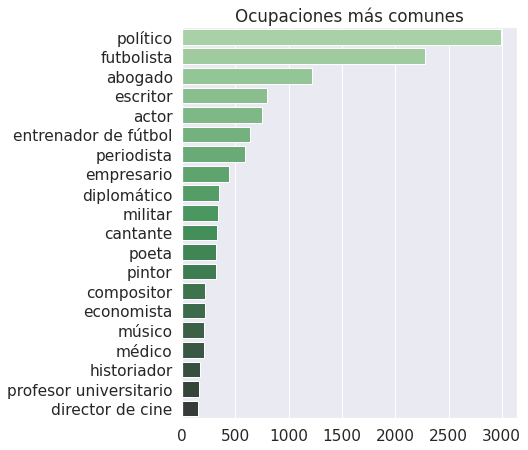

In [434]:
ax = sb.countplot(data=chilenosConWikipediaInfo,y = 'occupationLabel',
                 palette="Greens_d",
              order=chilenosConWikipediaInfo['occupationLabel'].value_counts().iloc[:20].index
                 )
ax.set_title('Ocupaciones más comunes')
ax.set_xlabel('')
ax.set_ylabel('')

ax.get_figure().savefig('ocupaciones.png',bbox_inches = 'tight')

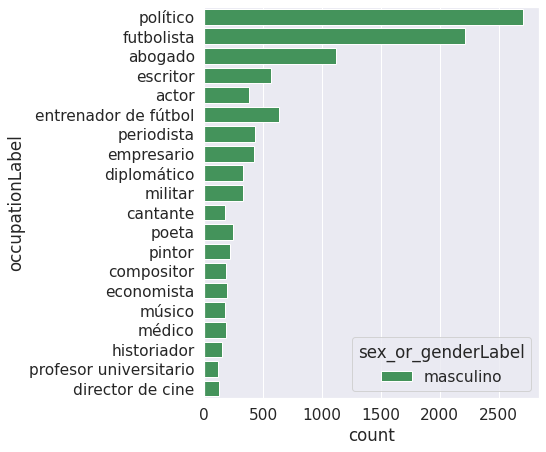

In [297]:
hombres = chilenosConWikipediaInfo[chilenosConWikipediaInfo['sex_or_genderLabel'] =='masculino']
ax = sb.countplot(data=hombres,y = 'occupationLabel',
                 hue="sex_or_genderLabel",palette="Greens_d",
              order=chilenosConWikipediaInfo['occupationLabel'].value_counts().iloc[:20].index
                 )
#sb.countplot

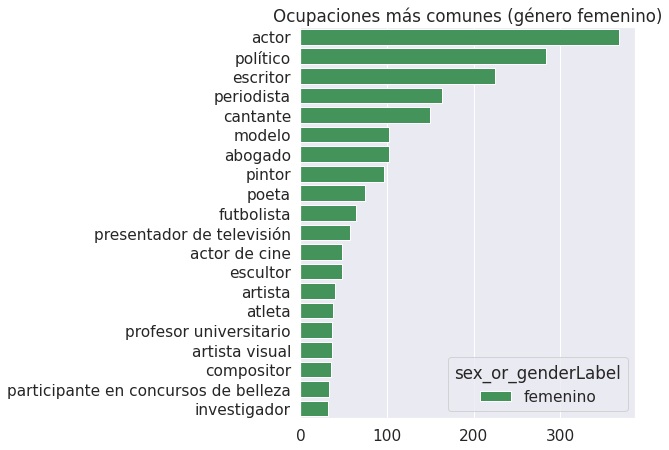

In [442]:
mujer = chilenosConWikipediaInfo[chilenosConWikipediaInfo['sex_or_genderLabel'] =='femenino']
ax = sb.countplot(data=mujer,y = 'occupationLabel',
                 hue="sex_or_genderLabel",palette="Greens_d",
              order=mujer['occupationLabel'].value_counts().iloc[:20].index,
                 
                 )

ax.set_title('Ocupaciones más comunes (género femenino)')
ax.set_xlabel('')
ax.set_ylabel('')

ax.get_figure().savefig('ocupacionesFemenino.png',bbox_inches = 'tight')

In [193]:
chilenosConWikipediaInfo['occupationLabel'].value_counts()[0:20]

político                  2993
futbolista                2280
abogado                   1219
escritor                   796
actor                      751
entrenador de fútbol       638
periodista                 590
empresario                 441
diplomático                341
militar                    332
cantante                   330
poeta                      317
pintor                     316
compositor                 218
economista                 213
músico                     205
médico                     203
historiador                167
profesor universitario     154
director de cine           152
Name: occupationLabel, dtype: int64

# Partido politico


In [200]:
partido = chilenosConWikipediaInfo[['item','member_of_political_partyLabel']].drop_duplicates()
partido['member_of_political_partyLabel'].value_counts()[0:20]

Partido Demócrata Cristiano                343
Partido Conservador                        240
Partido Liberal                            211
Renovación Nacional                        184
Partido Socialista de Chile                175
Unión Demócrata Independiente              168
Partido Radical                            165
Partido por la Democracia                  117
Partido Nacional                            83
Partido Comunista de Chile                  75
Partido Liberal Democrático                 65
Partido Radical de Chile                    46
candidato independiente                     39
Movimiento de Izquierda Revolucionaria      27
Evolución Política                          17
Revolución Democrática                      13
Partido Agrario Laborista                   12
Partido Democrático                         11
Partido Demócrata                            8
Movimiento Nacional-Socialista de Chile      8
Name: member_of_political_partyLabel, dtype: int64

In [440]:
pd.DataFrame(partido['member_of_political_partyLabel'].value_counts()[0:20])

,member_of_political_partyLabel
Partido Demócrata Cristiano,343
Partido Conservador,240
Partido Liberal,211
Renovación Nacional,184
Partido Socialista de Chile,175
Unión Demócrata Independiente,168
Partido Radical,165
Partido por la Democracia,117
Partido Nacional,83
Partido Comunista de Chile,75


# Lugar de nacimiento

In [444]:
chilenosConWikipediaInfo[['item','place_of_birthLabel']].drop_duplicates()['place_of_birthLabel'].value_counts()[0:20]

Santiago de Chile    3764
Valparaíso            448
Chile                 421
Concepción            347
Viña del Mar          208
Rancagua              169
Talca                 169
Antofagasta           163
La Serena             156
Iquique               127
Chillán               119
Temuco                117
Valdivia              116
Punta Arenas           95
Curicó                 93
Osorno                 92
Copiapó                76
Quillota               68
Talcahuano             66
Puerto Montt           61
Name: place_of_birthLabel, dtype: int64

In [456]:
ciudad = chilenosConWikipediaInfo[['item','place_of_birthLabel']].drop_duplicates()['place_of_birthLabel'].value_counts()[0:20]

<AxesSubplot:title={'center':'Lugar de nacimiento'}>

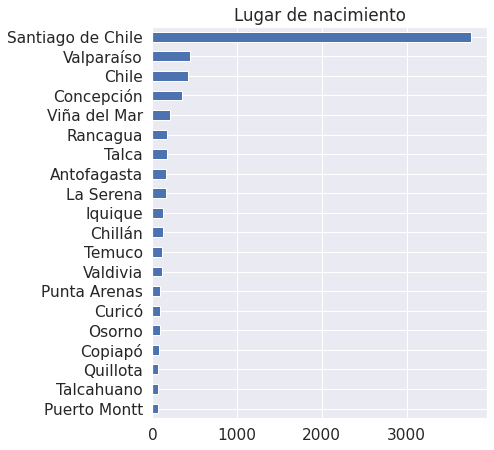

In [485]:
chilenosConWikipediaInfo[['item','place_of_birthLabel']].drop_duplicates()['place_of_birthLabel'].value_counts()[0:20].sort_values().plot(kind='barh',title='Lugar de nacimiento')

In [470]:
top_chilenos['place_of_birthLabel'].value_counts()

Santiago de Chile    6754
Valparaíso            792
Chile                 605
Concepción            566
Viña del Mar          342
Talca                 298
Antofagasta           262
La Serena             252
Rancagua              239
Chillán               195
Iquique               194
Temuco                188
Valdivia              180
Curicó                157
Punta Arenas          150
Osorno                144
Copiapó               125
San Fernando          105
Puerto Montt          101
Talcahuano             97
Quillota               95
Arica                  86
Coquimbo               86
Los Ángeles            85
Ovalle                 72
Linares                69
San Antonio            69
Name: place_of_birthLabel, dtype: int64

In [454]:
top_ciudades

,place_of_birthLabel
126,Viña del Mar
127,Viña del Mar
128,Viña del Mar
130,Viña del Mar
131,Viña del Mar
...,...
19414,Ñiquén
19415,Ñiquén
19513,Westminster
19567,Viña del Mar


# Fechas

In [252]:
fechas = chilenosConWikipediaInfo[['itemLabel','date_of_birth','date_of_death']].drop_duplicates()
fechas['nacimiento'] = pd.to_datetime(fechas['date_of_birth'],  errors='coerce')

fechas['muerte'] = pd.to_datetime(fechas['date_of_death'],  errors='coerce')

In [253]:
#gente nacida en el siglo XXI
fechas[fechas['nacimiento'].dt.year >1999].shape

(179, 5)

In [254]:
#gente nacida antes del siglo XX

fechas[fechas['nacimiento'].dt.year < 1900].shape

(2221, 5)

In [330]:
11868-(179+2221+9150)

318

In [328]:
fechas[(fechas['nacimiento'].dt.year > 1900) &  (fechas['nacimiento'].dt.year < 2000)].shape

(9150, 5)

In [387]:
nacimientos =pd.DataFrame.from_dict(
{'Antes de 1900':fechas[fechas['nacimiento'].dt.year < 1900].shape[0],
    'Entre 1900 y 1950':fechas[(fechas['nacimiento'].dt.year > 1900) &  (fechas['nacimiento'].dt.year < 1951)].shape[0],
               'Entre 1950 y 1999':fechas[(fechas['nacimiento'].dt.year > 1950) &  (fechas['nacimiento'].dt.year < 2000)].shape[0],
               'Desde 2000':fechas[fechas['nacimiento'].dt.year >1999].shape[0]

               },orient='index',columns=['cantidad']).T


In [388]:
nacimientos

,Antes de 1900,Entre 1900 y 1950,Entre 1950 y 1999,Desde 2000
cantidad,2221,3802,5348,179


Text(0, 0.5, 'Cantidad de Gente nacida en ese periodo')

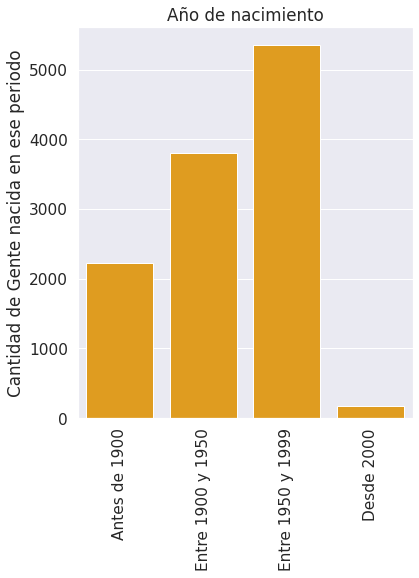

In [384]:
import seaborn as sb
g= sb.barplot(data=nacimientos,color='orange')
g.tick_params(axis='x', rotation=90)
g.set_title('Año de nacimiento')
g.set_ylabel('Cantidad de Gente nacida en ese periodo')


In [389]:
nacimientos

,Antes de 1900,Entre 1900 y 1950,Entre 1950 y 1999,Desde 2000
cantidad,2221,3802,5348,179


In [257]:
#vemos el mes más comun de muerte
fechas['muerte'].dt.month.value_counts()

1.0     1225
7.0      350
8.0      346
9.0      343
6.0      324
4.0      307
11.0     301
10.0     294
3.0      291
5.0      283
12.0     273
2.0      226
Name: muerte, dtype: int64

In [263]:
#quitamos el 1, porque hay mucha gente puesta el 1 de enero
fechas[(fechas['muerte'].dt.day !=1) ].muerte.dt.month.value_counts()

7.0     338
8.0     337
9.0     325
6.0     310
1.0     301
4.0     293
11.0    283
10.0    283
3.0     278
5.0     270
12.0    262
2.0     213
Name: muerte, dtype: int64

# Más vistos 

In [265]:
!pip3 install mwviews

  Created wheel for mwviews: filename=mwviews-0.1.0-py3-none-any.whl size=7781 sha256=570f6ea9578cdc05b3bb5b04fa892c3a0ac4ac8d613641f51b80fd487f562e08
  Stored in directory: /home/user/.cache/pip/wheels/4d/c1/af/b33379cae84c4f1f057e6b696bc66746466e9ec6faf2724e80
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=bffe733b1d85f3ace8275c398d2f64f2e25bef2566fa57bf83507cc03c936ee9
  Stored in directory: /home/user/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built mwviews docopt


In [ ]:
#instalamos e importamos la libreria mwviews para cargar los pageviews
import mwviews
from mwviews.api import PageviewsClient

p = PageviewsClient('all-access',parallelism=30)
articulos_es = chilenosConWikipedia[chilenosConWikipedia['sitelink_lang']=='es']['article'].apply(lambda x:x.split('/')[-1])
articulos_es = list(set(articulos_es))
views = p.article_views('es.wikipedia', articulos_es, granularity='monthly', start='20210101', end='20210901')

In [ ]:
#y lo leomos con pandas
views_pd = pd.DataFrame.from_dict(views,orient='index').T

In [322]:
views_pd['2021'] =

,2021-08-01
Augusto_Pinochet,53763.0
Pablo_Neruda,44617.0
Isabel_Allende,40046.0
Mon_Laferte,34258.0
Yasna_Provoste,32459.0
Salvador_Allende,31586.0
Pedro_Pascal,31478.0
Humberto_Suazo,30828.0
Gabriela_Mistral,27051.0
Etienne_Bobenrieth,26796.0


In [324]:
# p = PageviewsClient('all-access',parallelism=500)
articulos_en = chilenosConWikipedia[chilenosConWikipedia['sitelink_lang']=='en']['article'].apply(lambda x:x.split('/')[-1])
articulos_en = list(set(articulos_en))
views_en = p.article_views('en.wikipedia', articulos_en, granularity='monthly', start='20210101', end='20210831')

ERROR while fetching and parsing ['https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Catalina_C%25C3%25A1ceres/monthly/2021010100/2021083100', 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Claudio_Orrego/monthly/2021010100/2021083100', 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Pedro_Rivera_%28footballer%29/monthly/2021010100/2021083100', 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Eryin_Sanhueza/monthly/2021010100/2021083100', 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Renzo_Y%25C3%25A1%25C3%25B1ez/monthly/2021010100/2021083100', 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Juan_Crist%25C3%25B3bal_Guarello/monthly/2021010100/2021083100', 'https://wikimedia.org/ap

Traceback (most recent call last):
  File "/home/user/.local/lib/python3.8/site-packages/mwviews/api/pageviews.py", line 134, in article_views
    results = self.get_concurrent(urls)
  File "/home/user/.local/lib/python3.8/site-packages/mwviews/api/pageviews.py", line 307, in get_concurrent
    return list(executor.map(f, urls))
  File "/usr/lib/python3.8/concurrent/futures/_base.py", line 619, in result_iterator
    yield fs.pop().result()
  File "/usr/lib/python3.8/concurrent/futures/_base.py", line 437, in result
    return self.__get_result()
  File "/usr/lib/python3.8/concurrent/futures/_base.py", line 389, in __get_result
    raise self._exception
  File "/usr/lib/python3.8/concurrent/futures/thread.py", line 57, in run
    result = self.fn(*self.args, **self.kwargs)
  File "/home/user/.local/lib/python3.8/site-packages/mwviews/api/pageviews.py", line 306, in <lambda>
    f = lambda url: requests.get(url, headers=self.headers).json()
  File "/usr/lib/python3/dist-packages/request

JSONDecodeError: Expecting value: line 1 column 1 (char 0)